In [1]:
from ndlib.models.DiffusionModel import DiffusionModel
import ndlib.models.ModelConfig as mc
import numpy as np
from random import choice
import random
from random import seed, choice
import future.utils
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import time

In [1]:
class Lobbyist:
    def __init__(self, m, strategy_matrix=None):
        self.m = m  # 'o' for optimist, 'p' for pessimist
        self.strategy_matrix = strategy_matrix  # N x T matrix or None
        self.current_strategy = None  # Current strategy vector for each iteration

    def set_strategy_for_iteration(self, iteration):
        if self.strategy_matrix is not None:
            self.current_strategy = self.strategy_matrix[:, iteration]
        else:
            # Generate a random strategy vector for this iteration if strategy matrix is not predefined
            self.current_strategy = np.random.randint(2, size=self.strategy_matrix.shape[0])

In [ ]:
class AlmondoModel(DiffusionModel):
    
    def __init__(self, graph, seed=None, lobbyists=None):
        super(self.__class__, self).__init__(graph, seed)

        self.discrete_state = False

        self.parameters = {
            "model": {
                "p_o": {
                    "descr": "Probability of event optimist model",
                    "range": [0, 1],
                    "optional": False
                },
                "p_p": {
                    "descr": "Probability of event pessimist model",
                    "range": [0, 1],
                    "optional": False
                },
                "l":{
                    "descr": "underreaction parameter",
                    "range": [0,1],
                    "optional": False
                }
            },
            "nodes": {},
            "edges": {}
        }

        self.name = "Almondo"
        self.n = self.graph.number_of_nodes()
        self.seed = seed
        self.status = None
        self.lobbyists = lobbyists if lobbyists else []

    def set_initial_status(self, configuration=None, status=None):
        super(AlmondoModel, self).set_initial_status(configuration)        
        
        if status is None:
            self.status = np.random.rand(self.n)
        else:
            self.status = status        

    def optimist_update(self, w, s):
        p_o = self.params['model']['p_o']
        p_p = self.params['model']['p_p']
        l = self.params['model']['l']
        p = w * p_o + (1 - w) * p_p
        return l * w + (1 - l) * w * (s * (p_o / p) + (1 - s) * ((1 - p_o) / (1 - p)))

    def pessimist_update(self, w, s):
        # Define the pessimistic update rule here
        pass

    def iteration(self, node_status=True):
        actual_status = self.status.copy()

        if self.actual_iteration == 0:
            self.actual_iteration += 1
            if node_status:
                return {"iteration": 0, "status": actual_status, "sender": None, "signal": None}
            else:
                return {"iteration": 0, "status": {}, "sender": None, "signal": None}
        
        # Choose a sender at random
        sender = random.randint(0, self.n-1)
        
        # Interact with peers
        p = actual_status[sender] * self.params['model']['p_o'] + (1- actual_status[sender]) * self.params['model']['p_p']
        signal = np.random.binomial(1, p)
        receivers = np.array(self.graph.neighbors(sender))
        
        # Update rule
        actual_status[receivers] = self.optimist_update(actual_status[receivers], signal)  

        # Influence from lobbyists
        for lobbyist in self.lobbyists:
            lobbyist.set_strategy_for_iteration(self.actual_iteration)
            for i, influence in enumerate(lobbyist.current_strategy):
                if influence == 1:
                    if lobbyist.m == 'o':
                        actual_status[i] = self.optimist_update(actual_status[i], 1)
                    elif lobbyist.m == 'p':
                        actual_status[i] = self.pessimist_update(actual_status[i], 1)
        
        self.actual_iteration += 1   
        self.status = actual_status 
        
        if node_status:
            return {"iteration": self.actual_iteration-1, "status": actual_status, "sender": sender, "signal": signal}
        else:
            return {"iteration": self.actual_iteration-1, "status": actual_status, "sender": sender, "signal": signal}

    def iteration_bunch(self, T=100):
        random.seed(self.seed)
        system_status = []
        for it in tqdm(range(T)):
            its = self.iteration()
            system_status.append(its)       
        return system_status

    def steady_state(self, max_iterations=1000000, nsteady=1000, sensibility=0.00001, node_status=True, progress_bar=True, drop_evolution=True):             
        system_status = []
        steady_it = 0

        for it in tqdm(range(max_iterations)):

            its = self.iteration(node_status=True)
            
            if it > 0:
                old = system_status[-1]['status']
                actual = its['status']
                res = np.abs(old - actual)
                if np.all((res < sensibility)):
                    steady_it += 1
                else:
                    steady_it = 0
                    
            system_status.append(its)
            
            if steady_it == nsteady:
                print(f'Convergence reached after {it} iterations')
                return system_status
                    
        return system_status


In [2]:
# class AlmondoModel(DiffusionModel):
    
#     def __init__(self, graph, seed=None):
#         super(self.__class__, self).__init__(graph, seed)

#         self.discrete_state = False

#         self.parameters = {
#             "model": {
#                 "p_o": {
#                     "descr": "Probability of event optimist model",
#                     "range": [0, 1],
#                     "optional": False
#                 },
#                 "p_p": {
#                     "descr": "Probability of event pessimist model",
#                     "range": [0, 1],
#                     "optional": False
#                 },
#                 "l":{
#                     "descr": "underreaction parameter",
#                     "range": [0,1],
#                     "optional": False
#                 }
#             },
#             "nodes": {},
#             "edges": {}
#         }

#         self.name = "Almondo"
#         self.n = self.graph.number_of_nodes()
#         self.seed = seed
#         self.status = None

#     def set_initial_status(self, configuration=None, status=None):
#         super(AlmondoModel, self).set_initial_status(configuration)        
        
#         if status is None:
#             self.status = np.random.rand(self.n)
#         else:
#             self.status = status        
            
            
#     # updating rule, optimist model
#     def optimist_update(self, w, s):
#         p_o = self.params['model']['p_o']
#         p_p = self.params['model']['p_p']
#         l = self.params['model']['l']
#         p = w * p_o + (1 - w) * p_p
#         return l * w + (1 - l) * w * (s * (p_o / p) + (1 - s) * ((1 - p_o) / (1 - p)))

#     def iteration(self, node_status=True):
#         actual_status = self.status.copy()

#         if self.actual_iteration == 0:
#             self.actual_iteration += 1
#             if node_status:
#                 return {"iteration": 0, "status": actual_status, "sender": None, "signal": None}
#             else:
#                 return {"iteration": 0, "status": {}, "sender": None, "signal": None}
        
#         #choose a sender at random
#         sender = random.randint(0, self.n-1)
        
#         # interact with peers
#         p = actual_status[sender] * self.params['model']['p_o'] + (1- actual_status[sender]) * self.params['model']['p_p']
#         signal = np.random.binomial(1, p)
#         receivers = np.array(self.graph.neighbors(sender))
        
#         #update rule
#         actual_status[receivers] = self.optimist_update(actual_status[receivers], signal)  
        
#         self.actual_iteration += 1   
#         self.status = actual_status 
        
#         if node_status:
#             return {"iteration": self.actual_iteration-1, "status": actual_status, "sender": sender, "signal": signal}
#         else:
#             return {"iteration": self.actual_iteration-1, "status": actual_status, "sender": sender, "signal": signal}
        
    
#     def iteration_bunch(self, T=100):
#         random.seed(self.seed)
#         system_status = []
#         for it in tqdm(range(T)):
#             its = self.iteration()
#             system_status.append(its)       
#         return system_status

#     def steady_state(self, max_iterations=1000000, nsteady=1000, sensibility=0.00001, node_status=True, progress_bar=True, drop_evolution=True):             
#         system_status = []
#         steady_it = 0

#         for it in tqdm(range(max_iterations)):

#             its = self.iteration(node_status=True)
            
#             if it > 0:
#                 old = system_status[-1]['status']
#                 actual = its['status']
#                 res = np.abs(old - actual)
#                 if np.all((res < sensibility)):
#                     steady_it += 1
#                 else:
#                     steady_it = 0
                    
#             system_status.append(its)
            
#             if steady_it == nsteady:
#                 print(f'Convergence reached after {it} iterations')
#                 return system_status
                    
#         return system_status
    
    


In [3]:
import networkx as nx

p_o = 0.01
p_p = 0.99
l = 0.8
n = 1000
p_er = 0.01
g = nx.erdos_renyi_graph(n,p_er)
initial_status = np.random.rand(n)

# Model selection
model = AlmondoModel(graph=g, seed=4)

print(model)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("p_o", p_o)
config.add_model_parameter("p_p", p_p)
config.add_model_parameter("l", l)
model.set_initial_status(configuration=config, status=initial_status)

In [4]:
iterations = model.iteration_bunch(T=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from cycler import cycler

#rcParams default settings
"https://matplotlib.org/stable/tutorials/introductory/customizing.html"

#rcParams settings
plt.style.use('ggplot')

rcParams['font.family'] = 'sans-serif'
rcParams['font.style'] = 'normal'

rcParams['figure.facecolor'] = 'white'

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = True

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.labelsize'] = 20
rcParams['axes.labelcolor'] = 'black'
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.linewidth'] = 3
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlepad'] = 4

rcParams['xtick.color'] = 'grey'
rcParams['ytick.color'] = 'grey'
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 0
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 0

rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 10

rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.1

#### Initial distribution of weights on the optimist model

In [6]:
weights = iterations[0]['status']

(-0.05, 1.05)

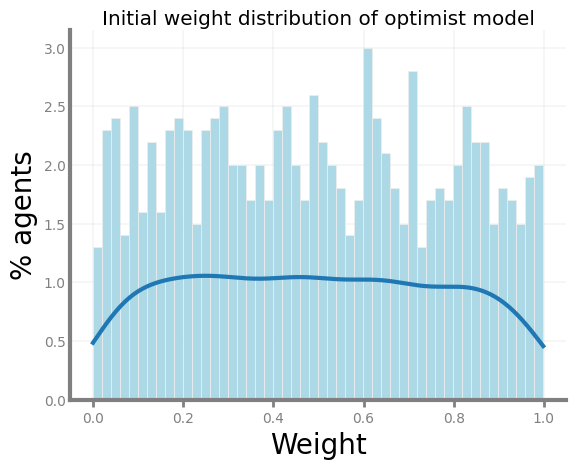

In [7]:
ax = sns.histplot(weights, bins=50, color='lightblue', alpha=1.0, stat='percent')
sns.kdeplot(weights, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel('Weight')
ax.set_ylabel('% agents')
ax.set_title('Initial weight distribution of optimist model')
ax.set_xlim(-0.05, 1.05)

#### Initial probabilities distribution

In [8]:
probabilities = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur

(-0.05, 1.05)

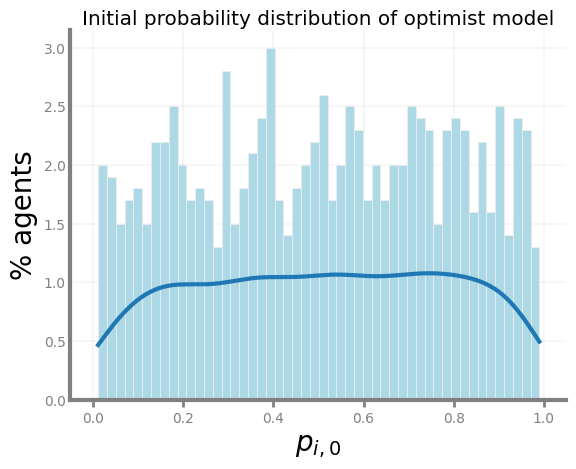

In [9]:
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
sns.kdeplot(probabilities, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel(r'$p_{i,0}$')
ax.set_ylabel('% agents')
ax.set_title('Initial probability distribution of optimist model')
ax.set_xlim(-0.05, 1.05)

#### Final distributions

In [10]:
weights = iterations[-1]['status']

In [11]:
min(weights)

0.012015995312607696

In [12]:
max(weights)

0.9941945134416839

Text(0.5, 1.0, 'Final weights distribution of optimist model')

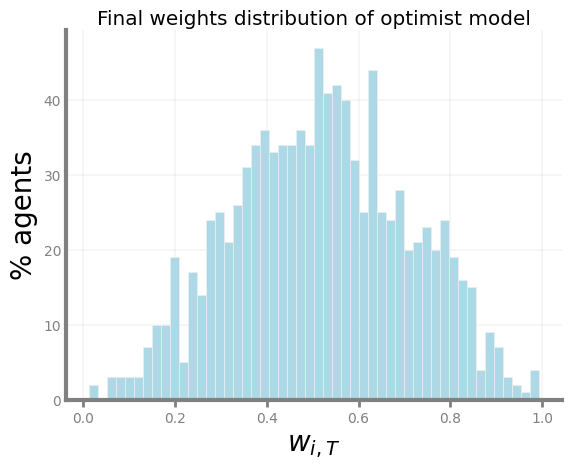

In [13]:
ax = sns.histplot(weights, bins=50, color='lightblue', alpha=1.0)
ax.set_xlabel(r'$w_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final weights distribution of optimist model')


In [14]:
probabilities = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur

(0.0, 1.0)

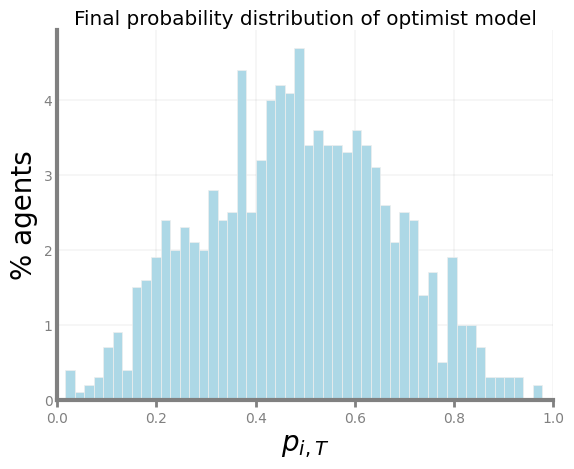

In [15]:
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
# sns.kdeplot(probabilities, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel(r'$p_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final probability distribution of optimist model')
ax.set_xlim(0.0, 1.0)

(0.0, 1.0)

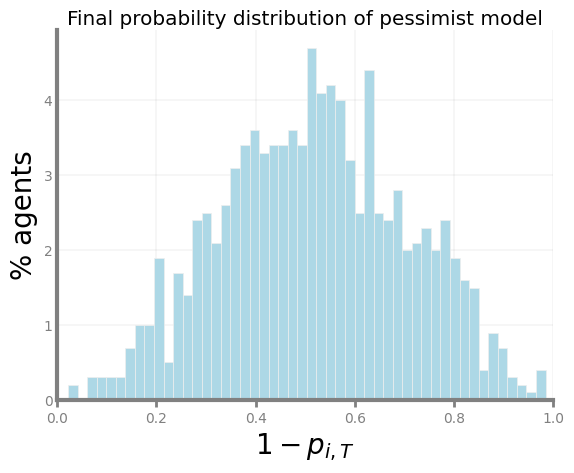

In [16]:
probabilities = 1-probabilities
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
ax.set_xlabel(r'$1 - p_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final probability distribution of pessimist model')
ax.set_xlim(0.0, 1.0)

In [17]:
from matplotlib.colors import LinearSegmentedColormap

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

spaghetti_hex_list = ['#357db0', '#18A558', '#ce2626']
spaghetti_cmap=get_continuous_cmap(spaghetti_hex_list)


def plotevolution(iterations, p_o, p_p, name=None, run=None, path='../plots/'):
    
    fig, ax = plt.subplots()

    spaghetti_hex_list = ['#357db0', '#18A558', '#ce2626']


    """
    Generates the plot

    :param filequintet: Output filequintet
    :param percentile: The percentile for the trend variance area
    """

    nodes2opinions = {}
    node2col = {}

    last_it = iterations[-1]['iteration'] + 1
    last_seen = {}

    for it in iterations:
        weights = it['status']
        sts = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur
        its = it['iteration']
        for n, v in enumerate(sts):
            if n in nodes2opinions:
                last_id = last_seen[n]
                last_value = nodes2opinions[n][last_id]

                for i in range(last_id, its):
                    nodes2opinions[n][i] = last_value

                nodes2opinions[n][its] = v
                last_seen[n] = its
            else:
                nodes2opinions[n] = [0]*last_it
                nodes2opinions[n][its] = v
                last_seen[n] = 0
                if v < 0.33:
                    node2col[n] = spaghetti_hex_list[0]
                elif 0.33 <= v <= 0.66:
                    node2col[n] = spaghetti_hex_list[1]
                else:
                    node2col[n] = spaghetti_hex_list[2]

    mx = 0
    for k, l in future.utils.iteritems(nodes2opinions):
        if mx < last_seen[k]:
            mx = last_seen[k]
        x = list(range(0, last_seen[k]))
        y = l[0:last_seen[k]]
        ax.plot(x, y, lw=1.5, alpha=0.5, color=node2col[k])
    plt.xlabel('t')
    plt.ylabel(r'$p_{i,t}$')
    plt.title('Optimist model probability evolution')
    plt.tight_layout()
    
    if name:
        plt.savefig(f'{path}/opinion_evolution_{name}_run{run}.png', bbox_inches='tight', facecolor='white')
    else:
        plt.show()
    plt.close()

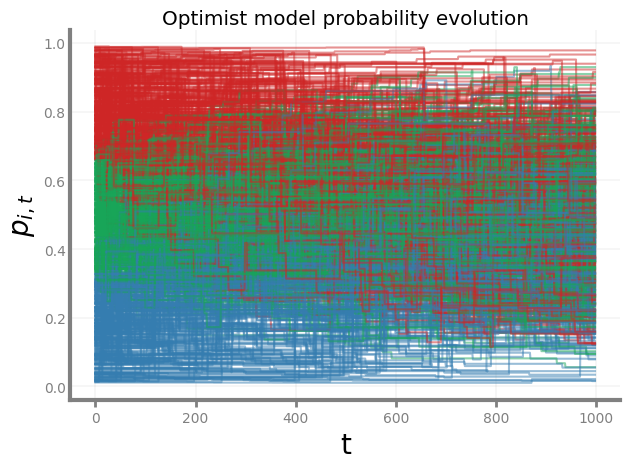

In [19]:
plotevolution(iterations, p_o, p_p)

# Il modello converge?

In [20]:
p_o = 0.01
p_p = 0.99
l = 0.8
n = 1000
p_er = 0.01
g = nx.erdos_renyi_graph(n,p_er)
initial_status = np.random.rand(n)

# Model selection
model = AlmondoModel(graph=g, seed=4)

print(model)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("p_o", p_o)
config.add_model_parameter("p_p", p_p)
config.add_model_parameter("l", l)
model.set_initial_status(configuration=config, status=initial_status)

In [21]:
iterations = model.steady_state(max_iterations=100000, nsteady=500, sensibility=0.0001)

  0%|          | 0/100000 [00:00<?, ?it/s]

Convergence reached after 93887 iterations


#### Initial distribution of weights on the optimist model

In [23]:
weights = iterations[0]['status']

(-0.05, 1.05)

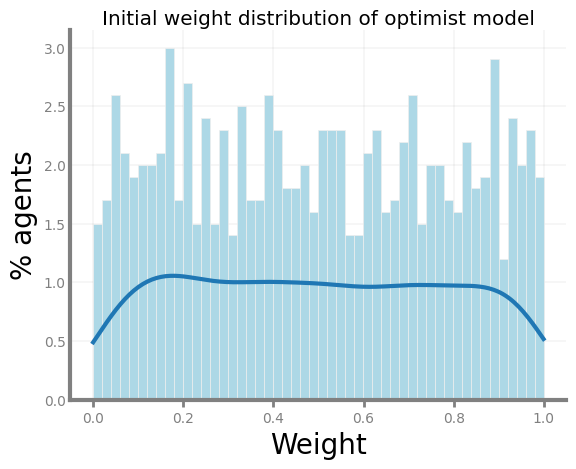

In [24]:
ax = sns.histplot(weights, bins=50, color='lightblue', alpha=1.0, stat='percent')
sns.kdeplot(weights, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel('Weight')
ax.set_ylabel('% agents')
ax.set_title('Initial weight distribution of optimist model')
ax.set_xlim(-0.05, 1.05)

#### Initial probabilities distribution

In [25]:
probabilities = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur

(-0.05, 1.05)

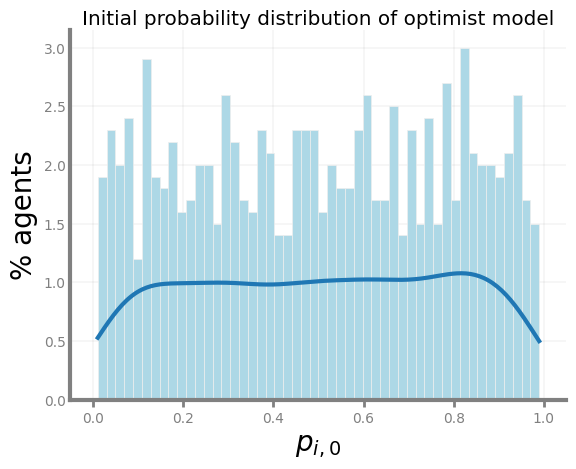

In [26]:
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
sns.kdeplot(probabilities, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel(r'$p_{i,0}$')
ax.set_ylabel('% agents')
ax.set_title('Initial probability distribution of optimist model')
ax.set_xlim(-0.05, 1.05)

#### Final distributions

In [27]:
weights = iterations[-1]['status']

In [28]:
min(weights)

1.0230319380548587e-25

In [29]:
max(weights)

0.0021833599827767256

Text(0.5, 1.0, 'Final weights distribution of optimist model')

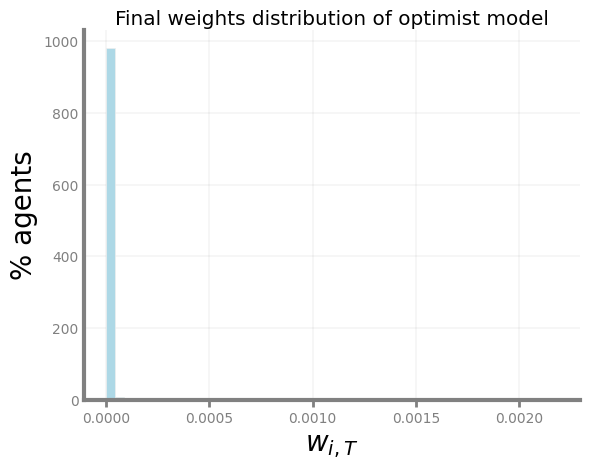

In [30]:
ax = sns.histplot(weights, bins=50, color='lightblue', alpha=1.0)
ax.set_xlabel(r'$w_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final weights distribution of optimist model')

In [31]:
probabilities = p_o * weights + p_p * (1-weights)  # update conditional probabilities of event will occur

In [32]:
probabilities

array([0.98999986, 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.98999672, 0.99      , 0.99      , 0.98999911,
       0.98999376, 0.99      , 0.99      , 0.99      , 0.98999998,
       0.9899998 , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.98999999, 0.99      , 0.98999997, 0.99      ,
       0.99      , 0.98999994, 0.99      , 0.98999999, 0.99      ,
       0.98999998, 0.98999787, 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.98999995, 0.99      , 0.99      ,
       0.99      , 0.99      , 0.98999997, 0.99      , 0.98999994,
       0.98999997, 0.99      , 0.98999989, 0.99      , 0.99      ,
       0.99      , 0.98999949, 0.99      , 0.99      , 0.98999971,
       0.99      , 0.98999997, 0.99      , 0.99      , 0.99      ,
       0.99      , 0.99      , 0.99      , 0.99      , 0.99      ,
       0.98999999, 0.99      , 0.99      , 0.99      , 0.99   

(0.0, 1.0)

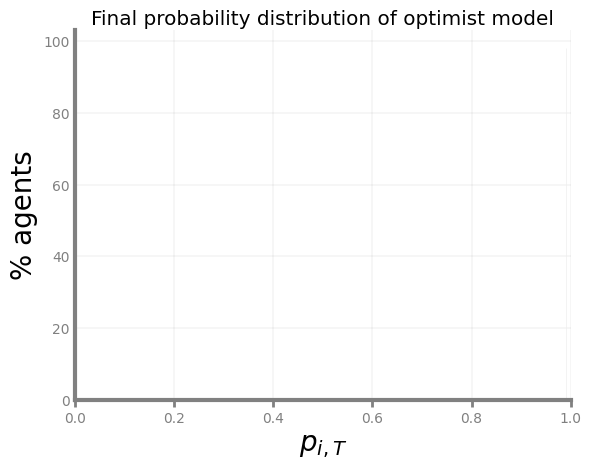

In [33]:
ax = sns.histplot(probabilities, bins = 50, color='lightblue', alpha=1.0, stat='percent')
# sns.kdeplot(probabilities, color='tab:blue', cut=0, ax=ax)
ax.set_xlabel(r'$p_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final probability distribution of optimist model')
ax.set_xlim(0.0, 1.0)

(0.0, 1.0)

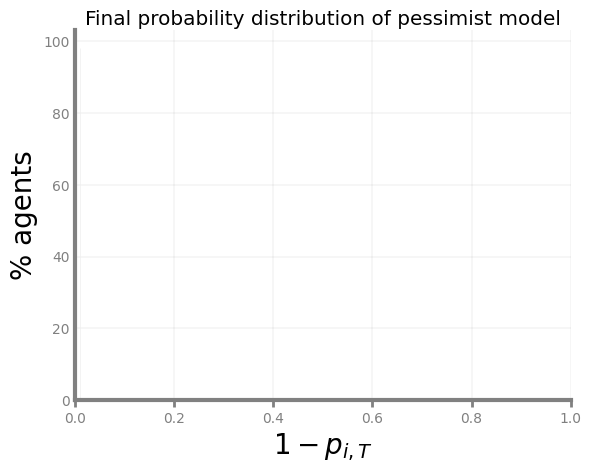

In [34]:
probabilities = 1-probabilities
ax = sns.histplot(probabilities, bins=50, color='lightblue', alpha=1.0, stat='percent')
ax.set_xlabel(r'$1 - p_{i,T}$')
ax.set_ylabel('% agents')
ax.set_title('Final probability distribution of pessimist model')
ax.set_xlim(0.0, 1.0)

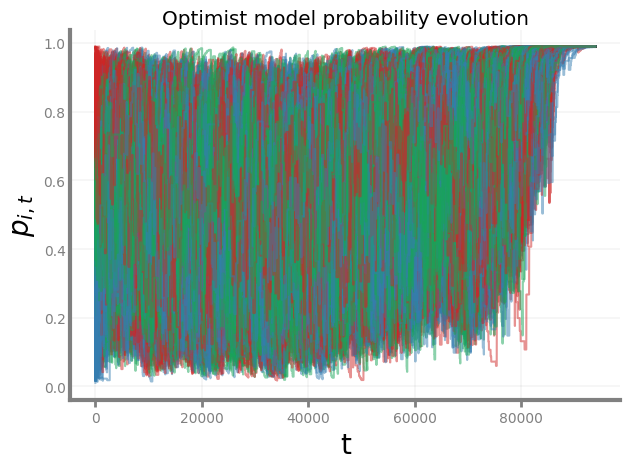

In [35]:
plotevolution(iterations, p_o, p_p)